11/30 VQ-VAE+gatedPixelCNN　K=64, training train, epoch50 size(112,80) kernel_a=15, kernel_b=15 VQ-VAE保存パラメータ読み込み test shuffle=False  
予測の正しさを確認 テストデータで確認する インデックスの場所毎の一致度確認 

In [1]:
record = 'model_naive_k_256' # 何についてデータ取るのか

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
import seaborn as sns
import datetime
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.edgecolor']='azure'
plt.rcParams['axes.facecolor']='white'
plt.rcParams['axes.edgecolor']='azure'

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid, save_image
from torchvision import transforms, utils

from vq_vae_model import *
from naive_pixelCNN import *
# from GatedPixelCNN import *
# from spot_pixelCNN import *


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
batch_size = 512
# VQ-VAE
embedding_dim = 64 # D
num_embeddings = 256 # K
num_hiddens = 128 # encoderのout_channels
num_residual_hiddens = 32 # residualのout_channels
num_residual_layers = 2 # residualの繰り返し数
commitment_cost = 0.25
decay = 0 # EMA使うか
# learning_rate = 1e-3
in_channels=color=3

# Pixel CNN
num_of_layers = 7 # マスクBの畳み込み層の数
num_of_channels = 32 # チャネル数
kernel_a = 7
kernel_b = 7

# Gated Pixel CNN
nlayers=12 # number of layers for pixelcnn
inchans=1 #number of input channels (currently only one is supported)
nfeats=16 #number of feature maps across the network
Klevels=num_embeddings

num_of_epochs = 50 # epoch
img_size = (112, 80) # H*W
img_num = 25 # 画像の枚数
d_today = datetime.date.today()

## Load Data

In [5]:
# train 162770 test 19962 valid 19867 all 202599 , size 3, 218, 178
training_data = datasets.CelebA(root="~/b2022_kodai/data", download=True, split= 'train', 
                                  transform=transforms.Compose([
                                    transforms.CenterCrop((img_size[0], img_size[1])) 
                                    if img_size[0] >= 109 or img_size[1] >= 89
                                    else transforms.CenterCrop((img_size[0]*2, img_size[1]*2)),
                                    transforms.Resize(img_size),
                                    transforms.ToTensor(),
                                  ]))

validation_data = datasets.CelebA(root="~/b2022_kodai/data",  download=True, split= 'valid',# target_type='identity',
                                  transform=transforms.Compose([
                                    transforms.CenterCrop((img_size[0], img_size[1])) 
                                    if img_size[0] >= 109 or img_size[1] >= 89
                                    else transforms.CenterCrop((img_size[0]*2, img_size[1]*2)),
                                    transforms.Resize(img_size),
                                    transforms.ToTensor(),
                                  ]))

# generation_data = datasets.CelebA(root="~/b2022_kodai/data",  download=True, split= 'test',# target_type='identity',
#                                   transform=transforms.Compose([
#                                     transforms.CenterCrop((img_size[0], img_size[1])) 
#                                     if img_size[0] >= 109 or img_size[1] >= 89
#                                     else transforms.CenterCrop((img_size[0]*2, img_size[1]*2)),
#                                     transforms.Resize(img_size),
#                                     transforms.ToTensor(),
#                                   ]))

Files already downloaded and verified
Files already downloaded and verified


In [6]:
training_loader = DataLoader(training_data, batch_size=batch_size, drop_last=True, shuffle=True, pin_memory=True)
training_eval_loader = DataLoader(training_data, batch_size=batch_size, drop_last=True, shuffle=False, pin_memory=True)
validation_loader = DataLoader(validation_data, batch_size=batch_size, drop_last=True, shuffle=False, pin_memory=True)
# generation_loader = DataLoader(generation_data, batch_size=batch_size, drop_last=True, shuffle=False, pin_memory=True)

In [7]:
model = Model(in_channels, num_hiddens, num_residual_layers, num_residual_hiddens, num_embeddings, embedding_dim, commitment_cost, decay).to(device)
model_path = f'1.experiment/VQ-VAE_CelebA_train/VQ_VAE_size112*80/K_change_new/K_256/VQ-VAE_epoch_20.pth'
model.load_state_dict(torch.load(model_path))
model.eval()

Model(
  (_encoder): Encoder(
    (_conv_1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (_conv_2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (_conv_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (_residual_stack): ResidualStack(
      (_layers): ModuleList(
        (0): Residual(
          (_block): Sequential(
            (0): ReLU(inplace=True)
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (2): ReLU(inplace=True)
            (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
        )
        (1): Residual(
          (_block): Sequential(
            (0): ReLU(inplace=True)
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (2): ReLU(inplace=True)
            (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
        )
      )


PixelCNN

PixelCNN
epoch: 0/50 train error: 4.643
match:4.782549674181562%
mse_original:0.058708172879720986
mse_reconstructions:0.057348830135245076
epoch: 1/50 train error: 4.210
epoch: 2/50 train error: 3.985
epoch: 3/50 train error: 3.814
epoch: 4/50 train error: 3.705
epoch: 5/50 train error: 3.637
epoch: 6/50 train error: 3.584
epoch: 7/50 train error: 3.539
epoch: 8/50 train error: 3.506
epoch: 9/50 train error: 3.481
epoch: 10/50 train error: 3.463
Model saved.
match:14.672411115545975%
mse_original:0.018898351804206247
mse_reconstructions:0.01770959564141537
epoch: 11/50 train error: 3.448
epoch: 12/50 train error: 3.428
epoch: 13/50 train error: 3.425
epoch: 14/50 train error: 3.412
epoch: 15/50 train error: 3.403
epoch: 16/50 train error: 3.393
epoch: 17/50 train error: 3.388
epoch: 18/50 train error: 3.376
epoch: 19/50 train error: 3.376
epoch: 20/50 train error: 3.369
Model saved.
match:16.08688474485749%
mse_original:0.01415944192558527
mse_reconstructions:0.01297861443048245
epoch

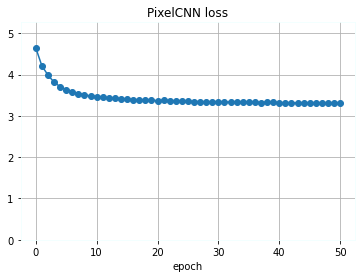

In [8]:
%%time
folder = f'./{d_today}/{record}/K={num_embeddings}_size{img_size}' # 保存場所
os.makedirs(folder, exist_ok=True)

pixel_cnn = PixelCNN(num_of_channels, num_of_layers, num_embeddings, kernel_a, kernel_b).to(device)
# pixel_cnn = PixelCNN(nlayers=nlayers, in_channels=inchans, nfeats=nfeats, Klevels=Klevels).to(device)
optimizer = optim.Adam(list(pixel_cnn.parameters()))
criterion = nn.CrossEntropyLoss()
train_losses = []
# test_losses = []
print('PixelCNN')

for epoch in range(num_of_epochs+1):
    # 学習
    train_errors = []
    pixel_cnn.train()
    for x, _ in training_loader:
        x = x.to(device)
        vq_output_eval = model._pre_vq_conv(model._encoder(x))
        _, data_recon, _, _, encoding_indices, encodings = model._vq_vae(vq_output_eval)
        target = encoding_indices.view(batch_size, data_recon.shape[2], data_recon.shape[3])
        x = target.unsqueeze_(1).to(device)
        loss = criterion(pixel_cnn(x.float()), target.squeeze())
        train_errors.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'epoch: {epoch}/{num_of_epochs} train error: {np.mean(train_errors):0.3f}')
    train_losses.append(np.mean(train_errors))
    if epoch % 10 == 0:
        if epoch != 0:
            torch.save(pixel_cnn.to('cpu').state_dict() , '{}/K={}_VQ-pixelCNN_epoch_{}.pth'.format(folder, num_embeddings ,epoch))
            print('Model saved.')
            pixel_cnn.to(device)

        # 再構成
        pixel_cnn.eval()
        test_error = []
        eval_img_max_loss_recon = [] # 再構成との誤差
        # validation
        eval_img_max_loss = [] # 入力画像との誤差
        index_match_degree = [] # indexの一致度
        match_one_hot = 0 # 一致したインデックスの内容
        with torch.no_grad():
            for x, _ in validation_loader:
                eval_originals = x.to(device)
                vq_output_eval = model._pre_vq_conv(model._encoder(eval_originals))
                _, eval_quantize, _, _, encoding_indices, encodings = model._vq_vae(vq_output_eval)
                eval_target = encoding_indices.view(batch_size, eval_quantize.shape[2], eval_quantize.shape[3])
                eval_target.unsqueeze_(1).to(device)
                
                sample = eval_target.float()
                sample_max = eval_target.float()

                out = pixel_cnn(sample).to(device)
                probs = F.softmax(out, dim=1)
                # max
                sample_max = torch.argmax(probs, 1).float().unsqueeze(1)
                sample_max = sample_max.long()

                # generate_max = decode_index(sample_max)
                
                b, c, h, w = sample.shape
                sample_max_onehot = sample_max.view(-1).unsqueeze(1)
                encodings = torch.zeros(sample_max_onehot.shape[0], model._vq_vae._num_embeddings).to(device)
                encodings.scatter_(1, sample_max_onehot, 1)

                # Quantize and unflatten
                quantized = torch.matmul(encodings, model._vq_vae._embedding.weight).view(-1, h, w, embedding_dim)

                # 生成
                quantized = quantized.permute(0, 3, 1, 2).contiguous()
                generate_max = model._decoder(quantized)

                eval_reconstructions = model._decoder(eval_quantize)
                
                # MSE
                eval_img_max_loss_recon.append(F.mse_loss(generate_max.data, eval_reconstructions).item()) # 画像のMSE
                eval_img_max_loss.append(F.mse_loss(generate_max.data, eval_originals).item()) # 画像のMSE
                # インデックスの一致度
                index_match_degree.append((torch.mean((sample_max==sample).float())).item())

        print(f'match:{np.mean(index_match_degree)*100}%')
        print(f'mse_original:{np.mean(eval_img_max_loss)}')
        print(f'mse_reconstructions:{np.mean(eval_img_max_loss_recon)}')


df = pd.DataFrame(train_losses, columns=['loss'])
df.to_csv('{}/loss.csv'.format(folder))
# df = pd.DataFrame(test_losses, columns=['epoch', 'test_error'])
# df.to_csv(f'{folder}/test_error.csv')

f = plt.figure() #  (default: [6.4, 4.8]) Width, height in inches.
ax = f.add_subplot(1,1,1) # 1行1列の1つめ
ax.plot(train_losses, marker="o")
ax.set_facecolor("white")
# ax.set_yscale('')
ax.grid()
ax.set_title('PixelCNN loss')
ax.set_xlabel('epoch')
ax.set_ylim(0, train_losses[1]*1.25)
plt.savefig(f'{folder}/loss.png', transparent=False)

# f = plt.figure() #  (default: [6.4, 4.8]) Width, height in inches.
# ax = f.add_subplot(1,1,1) # 1行2列の1つめ
# ax.plot(np.array(test_losses)[:,0], np.array(test_losses)[:,1], marker="o")
# # ax.set_yscale('')
# ax.set_title('PixelCNN testloss')
# ax.set_xlabel('epoch')
# plt.savefig(f'{folder}/testloss.png')

sample = torch.Tensor(img_num, 1, data_recon.shape[2], data_recon.shape[3]).to(device) # 生成用
sample.fill_(0)

for i in range(data_recon.shape[2]):
    for j in range(data_recon.shape[3]):
        out = pixel_cnn(sample).to(device)
        probs = F.softmax(out[:, :, i, j], dim=1)
        sample[:, :, i, j] = torch.multinomial(probs, 1).float()

sample = sample.long()
sample = sample.view(-1).unsqueeze(1)


encodings = torch.zeros(sample.shape[0], model._vq_vae._num_embeddings).to(device)
encodings.scatter_(1, sample, 1)

# Quantize and unflatten
quantized = torch.matmul(encodings, model._vq_vae._embedding.weight).view(-1, data_recon.shape[2], data_recon.shape[3], 64)

# 生成
quantized = quantized.permute(0, 3, 1, 2).contiguous()
generate = model._decoder(quantized)

save_image(generate.data, f"{folder}/k_{num_embeddings}.png", nrow=5, padding=0,  normalize=True)

